### Visualize results from single point mimics simulation at a NEON site
Will Wieder, Nov 2023

In [1]:
%load_ext autoreload
%autoreload 2

from glob import glob
from os.path import join

import calendar

import tqdm
import cftime
import dask

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import cm

from distributed import wait

import warnings
warnings.simplefilter("ignore", category=FutureWarning)

%matplotlib inline

#### Fetch cluster

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='2:30:00', # Amount of wall time
        interface='ext', # Interface to use  'lo' provided a cluster window, below.
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [3]:
# -- read only these variables from the whole netcdf files
def preprocess (ds):
    variables = ['TOTLITC','TOTMICC','TOTSOMC',
                 'TOTLITN','TOTMICN','TOTSOMN',
                 'LIT_MET_C_vr','LIT_STR_C_vr',
                 'MIC_COP_C_vr','MIC_OLI_C_vr',
                 'SOM_AVL_C_vr', 'SOM_CHEM_C_vr', 'SOM_PHYS_C_vr',
                 'TOTVEGC','TOTECOSYSC',
                 'GPP','AR','HR']

    ds_new= ds[variables]
    ds_new['TOT_SOM_C_vr']= ds_new.SOM_AVL_C_vr + ds_new.SOM_CHEM_C_vr + ds_new.SOM_PHYS_C_vr
    ds_new['TOT_SOM_C_vr'].attrs['units'] = ds_new['SOM_AVL_C_vr'].attrs['units']
    ds_new['TOT_LIT_C_vr']= ds_new.LIT_MET_C_vr + ds_new.LIT_STR_C_vr 
    ds_new['TOT_LIT_C_vr'].attrs['units'] = ds_new['LIT_MET_C_vr'].attrs['units']
    ds_new['TOT_MIC_C_vr']= ds_new.MIC_COP_C_vr + ds_new.MIC_OLI_C_vr 
    ds_new['TOT_MIC_C_vr'].attrs['units'] = ds_new['MIC_COP_C_vr'].attrs['units']

    return ds_new

In [4]:
# -- fix timestamp on CTSM files so they can be matched with eval files
def fix_time (ds):
    '''
    fix time formatting with reading multiple cesm files.
    '''
    nsteps = len(ds.time)
    yr0 = ds['time.year'][0].values
    month0 = ds['time.month'][0].values
    day0 = ds['time.day'][0].values

    date = cftime.datetime(yr0,month0,day0).isoformat() 
    ds['time'] = xr.cftime_range(date, periods=nsteps, freq='30min')
    ds['time']= ds['time'].dt.strftime("%Y-%m-%d %H:%M:%S")
    return ds

def fix_time_h0 (ds, MIM = False):
    nsteps = len(ds.time)
    yr0 = ds['time.year'][0].values
    month0 = ds['time.month'][0].values - 1 
    day0=1
    date = cftime.datetime(yr0,month0,day0).isoformat() 
    ds['time'] = xr.cftime_range(date, periods=nsteps, freq='M')
    #ds['time']= ds['time'].dt.strftime("%Y-%m").astype("datetime64[ns]")
    return ds

In [5]:
neon_sites2 = ['BART'] # for testing
failed_sites = [] # -- list for saving failed sites
months = ['99-06.nc']
defyears = ['2018','2019','2020','2021'] 
daily = False
years = ['2018', '2019', '2020', '2021']
years = ['1014', '1015', '1017', '1018']

cases = [neon_sites2[0] + '_mimics_spin',
         neon_sites2[0] + '_mimics_fi_betaTestB_spin',
         neon_sites2[0] + '_mimics_betaTestA_spin',
         neon_sites2[0] + '_mimics_fW_betaTest3_spin']

for neon_site in neon_sites2:
    try:
        sim_files0, sim_files1, sim_files2, sim_files3 = [], [], [], []
        sim_path0 = '/glade/derecho/scratch/wwieder/mimics_NEON/archive/'+cases[0]+'/lnd/hist/'
        sim_path1 = '/glade/derecho/scratch/wwieder/mimics_NEON/archive/'+cases[1]+'/lnd/hist/'
        sim_path2 = '/glade/derecho/scratch/wwieder/mimics_NEON/archive/'+cases[2]+'/lnd/hist/'
        sim_path3 = '/glade/derecho/scratch/wwieder/mimics_NEON/archive/'+cases[3]+'/lnd/hist/'

        for month in months:
            sim_files0.extend(sorted(glob(join(sim_path0,cases[0]+".clm2.h0.*"+month))))
            sim_files1.extend(sorted(glob(join(sim_path1,cases[1]+".clm2.h0.*"+month))))
            sim_files2.extend(sorted(glob(join(sim_path2,cases[2]+".clm2.h0.*"+month))))
            sim_files3.extend(sorted(glob(join(sim_path3,cases[3]+".clm2.h0.*"+month))))
        
        ann_files0 = []
        ann_files1 = []
        ann_files2 = []
        # Monthly history files for climatology
        if daily == False:
            for year in years:
                ann_files0.extend(sorted(glob(join(sim_path0,cases[0]+".clm2.h0."+year+"*.nc"))))
                ann_files1.extend(sorted(glob(join(sim_path1,cases[1]+".clm2.h0."+year+"*.nc"))))

            # Read in CENTURY case
            def_path = '/glade/derecho/scratch/wwieder/mimics_NEON/archive/'+neon_site+'.transient/lnd/hist/'
            print(def_path)
            for year in defyears:
                ann_files2.extend(sorted(glob(join(def_path,neon_site+".transient.clm2.h0."+year+"*.nc"))))

        else: # to read in daily data
            scratch  = '/glade/derecho/scratch/wwieder/'
            sim_path = scratch+'mimics_NEON/archive/' + neon_site + '_mimics.transient/lnd/hist/'
            def_path = scratch+'NEON_cases/archive/' + neon_site + '.MSBio_forcing.transient/lnd/hist/'
            for year in defyears:
                ann_files0.extend(sorted(glob(join(sim_path,neon_site+"_mimics.transient.clm2.h1."+year+"*.nc"))))
                ann_files1.extend(sorted(glob(join(def_path,neon_site+".MSBio_forcing.transient.clm2.h1."+year+"*.nc"))))

        print('sim files0 '+sim_files0[-1])
        print('ann files0 '+ann_files0[-1])
        print('ann files1 '+ann_files1[-1])
        print("All simulation files for all years: [", len(sim_files0), "files]")
        print ('---------------------------')
        print ("Reading data for "+neon_site)

        # Read in datasets
        ds0 = xr.open_mfdataset(sim_files0, decode_times=True, combine='by_coords', parallel=True,preprocess=preprocess)
        ds1 = xr.open_mfdataset(sim_files1, decode_times=True, combine='by_coords', parallel=True,preprocess=preprocess)
        ds2 = xr.open_mfdataset(sim_files2, decode_times=True, combine='by_coords', parallel=True,preprocess=preprocess)
        ds3 = xr.open_mfdataset(sim_files3, decode_times=True, combine='by_coords', parallel=True,preprocess=preprocess)
        print(' ** finished time series ** ')
        # annual climatology
        dsAnn0 = xr.open_mfdataset(ann_files0, decode_times=True, combine='by_coords', parallel=True)
        dsAnn1 = xr.open_mfdataset(ann_files1, decode_times=True, combine='by_coords', parallel=True)
        dsAnn2 = xr.open_mfdataset(ann_files2, decode_times=True, combine='by_coords', parallel=True)
        print(' ** finished climatology **')
        
    except Exception as e: 
        print (e)
        print ('THIS SITE FAILED:', neon_site)
        failed_sites.append(neon_site)
        pass


/glade/derecho/scratch/wwieder/mimics_NEON/archive/BART.transient/lnd/hist/
sim files0 /glade/derecho/scratch/wwieder/mimics_NEON/archive/BART_mimics_spin/lnd/hist/BART_mimics_spin.clm2.h0.3299-06.nc
ann files0 /glade/derecho/scratch/wwieder/mimics_NEON/archive/BART_mimics_spin/lnd/hist/BART_mimics_spin.clm2.h0.1018-12.nc
ann files1 /glade/derecho/scratch/wwieder/mimics_NEON/archive/BART_mimics_fi_betaTestB_spin/lnd/hist/BART_mimics_fi_betaTestB_spin.clm2.h0.1018-12.nc
All simulation files for all years: [ 33 files]
---------------------------
Reading data for BART
 ** finished time series ** 
 ** finished climatology **


## Annual climatology of daily or monthly data

In [6]:
# Fix time
if daily == False :
    fix_time_h0(dsAnn0)
    fix_time_h0(dsAnn1)
    fix_time_h0(dsAnn2)

# Drop lndgrid
dsAnn0 = dsAnn0.isel(lndgrid=0)
dsAnn1 = dsAnn1.isel(lndgrid=0)
dsAnn2 = dsAnn2.isel(lndgrid=0)

In [7]:
# Monthly climatologies
if daily == False:
    dsAnn0_sd = dsAnn0.groupby('time.month').std('time')
    dsAnn1_sd = dsAnn1.groupby('time.month').std('time')
    dsAnn2_sd = dsAnn2.groupby('time.month').std('time')

    dsAnn0 = dsAnn0.groupby('time.month').mean()   
    dsAnn1 = dsAnn1.groupby('time.month').mean()   
    dsAnn2 = dsAnn2.groupby('time.month').mean()   
else:
    dsAnn['NEE'] = -(dsAnn.GPP-dsAnn.AR-dsAnn.HR)
    dsAnn2['NEE'] = -(dsAnn2.GPP-dsAnn2.AR-dsAnn2.HR)

    dsAnn['W_SCALAR_l3'] = dsAnn['W_SCALAR'].isel(levsoi=2)
    dsAnn2['W_SCALAR_l3'] = dsAnn2['W_SCALAR'].isel(levsoi=2)
    dsAnn['TSOI_l3'] = dsAnn['TSOI'].isel(levgrnd=2)
    dsAnn2['TSOI_l3'] = dsAnn2['TSOI'].isel(levgrnd=2)

    dsAnn2_sd = dsAnn2.groupby('time.dayofyear').std('time')
    dsAnn_sd = dsAnn.groupby('time.dayofyear').std('time')

    dsAnn2 = dsAnn2.groupby('time.dayofyear').mean('time')
    dsAnn = dsAnn.groupby('time.dayofyear').mean('time')

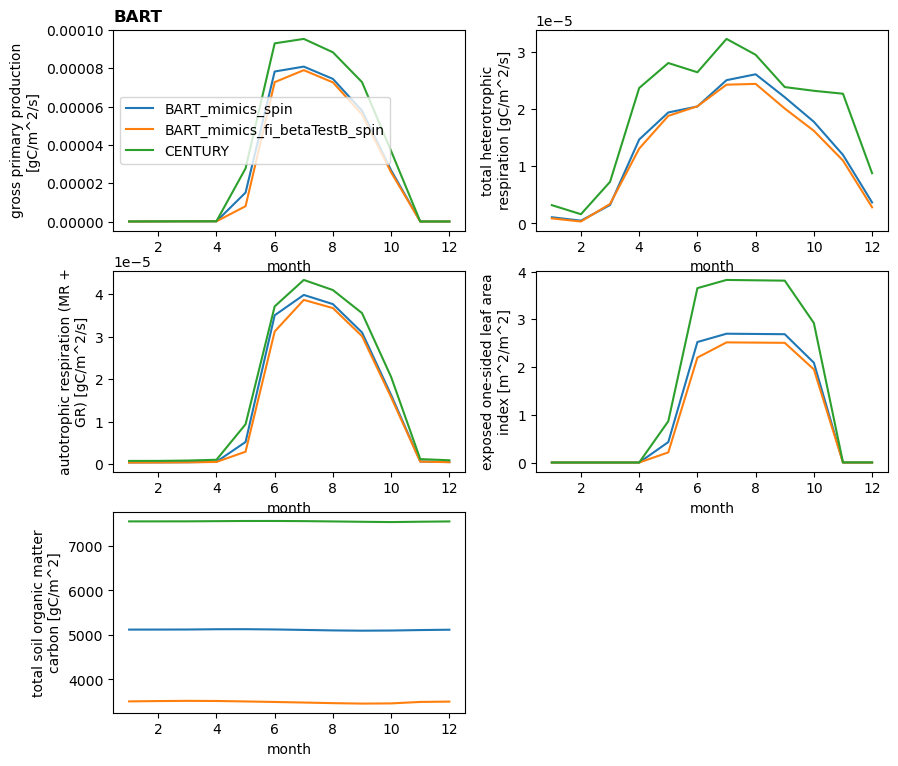

In [8]:
plt.figure(figsize=[10,12])
if daily == False:
    var=['GPP','HR','AR', 
         #'NET_NMIN', 'NEE','SMINN',
         'ELAI','TOTSOMC']
else:
    var=['GPP','HR','AR', 
         'NEE','W_SCALAR_l3','TSOI_l3',
         'ELAI']

for i in range(len(var)):
    plt.subplot(4, 2, (1+i))
    dsAnn0[var[i]].plot(label=cases[0])
    dsAnn1[var[i]].plot(label=cases[1])
    dsAnn2[var[i]].plot(label='CENTURY')
    if daily == True:
        #if var[i]== 'MIC_COP_C_vr':
        #    dsAnn[var[i]].isel(levsoi=2).plot(label='COP')
        #   dsAnn['MIC_OLI_C_vr'].isel(levsoi=2).plot(label='OLI')
        #    plt.legend() 
        #else:
        plt.fill_between(dsAnn.dayofyear, 
                         dsAnn[var[i]]-dsAnn_sd[var[i]], dsAnn[var[i]]+dsAnn_sd[var[i]] ,
                         alpha=0.25, color = 'blue')
        plt.fill_between(dsAnn2.dayofyear, 
                         dsAnn2[var[i]]-dsAnn2_sd[var[i]], dsAnn2[var[i]]+dsAnn2_sd[var[i]] ,
                         alpha=0.25, color = 'orange')

    #plt.xlim(0.9,12.1)
    if i == 0: 
        plt.legend() 
        plt.title(neon_sites2[0], loc='left', fontsize='large', fontweight='bold') ;

## Check MIMICS spinup

In [9]:
# select which time series to read in
ds0 = ds0.isel(lndgrid=0)
ds0['time'] = ds0["time.year"]
ds0 = ds0.load()
ds0

ds1 = ds1.isel(lndgrid=0)
ds1['time'] = ds1["time.year"]
ds1 = ds1.load()
ds1

ds2 = ds2.isel(lndgrid=0)
ds2['time'] = ds2["time.year"]
ds2 = ds2.load()
ds2

ds3 = ds3.isel(lndgrid=0)
ds3['time'] = ds3["time.year"]
ds3 = ds3.load()
ds3

<xarray.Dataset>
Dimensions:        (time: 30, levsoi: 20)
Coordinates:
  * levsoi         (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.06 5.95 6.94 8.03
  * time           (time) int64 99 199 299 399 499 ... 2599 2699 2799 2899 2999
Data variables: (12/21)
    TOTLITC        (time) float32 367.1 384.3 388.8 392.1 ... 408.6 408.0 408.2
    TOTMICC        (time) float32 160.4 174.3 181.0 185.1 ... 205.9 206.3 206.6
    TOTSOMC        (time) float32 821.2 1.232e+03 ... 3.171e+03 3.173e+03
    TOTLITN        (time) float32 6.511 6.489 6.552 6.621 ... 6.995 6.979 6.984
    TOTMICN        (time) float32 19.3 19.66 20.52 21.3 ... 27.86 27.97 28.05
    TOTSOMN        (time) float32 99.13 149.0 191.4 227.2 ... 424.5 425.1 425.6
    ...             ...
    GPP            (time) float32 6.459e-05 6.457e-05 ... 6.769e-05 6.771e-05
    AR             (time) float32 2.785e-05 2.779e-05 ... 2.802e-05 2.802e-05
    HR             (time) float32 1.929e-05 2.109e-05 ... 2.294e-05 2.295e-05
    TOT_SOM_C_vr   (time, levsoi) float32 3.567e+03 2.853e+03 ... 0.0 0.0
    TOT_LIT_C_vr   (time, levsoi) float32 3.277e+03 1.822e+03 ... 0.0 0.0
    TOT_MIC_C_vr   (time, levsoi) float32 107.1 134.4 130.5 ... 0.0 0.0 0.0
Attributes: (12/101)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 02/01/24 16:27:02
    source:                               Community Terrestrial Systems Model
    hostname:                             derecho
    ...                                   ...
    cft_irrigated_tropical_corn:          62
    cft_tropical_soybean:                 63
    cft_irrigated_tropical_soybean:       64
    time_period_freq:                     month_1
    Time_constant_3Dvars_filename:        ./BART_mimics_fW_betaTest3_spin.clm...
    Time_constant_3Dvars:                 ZSOI:DZSOI:WATSAT:SUCSAT:BSW:HKSAT:...

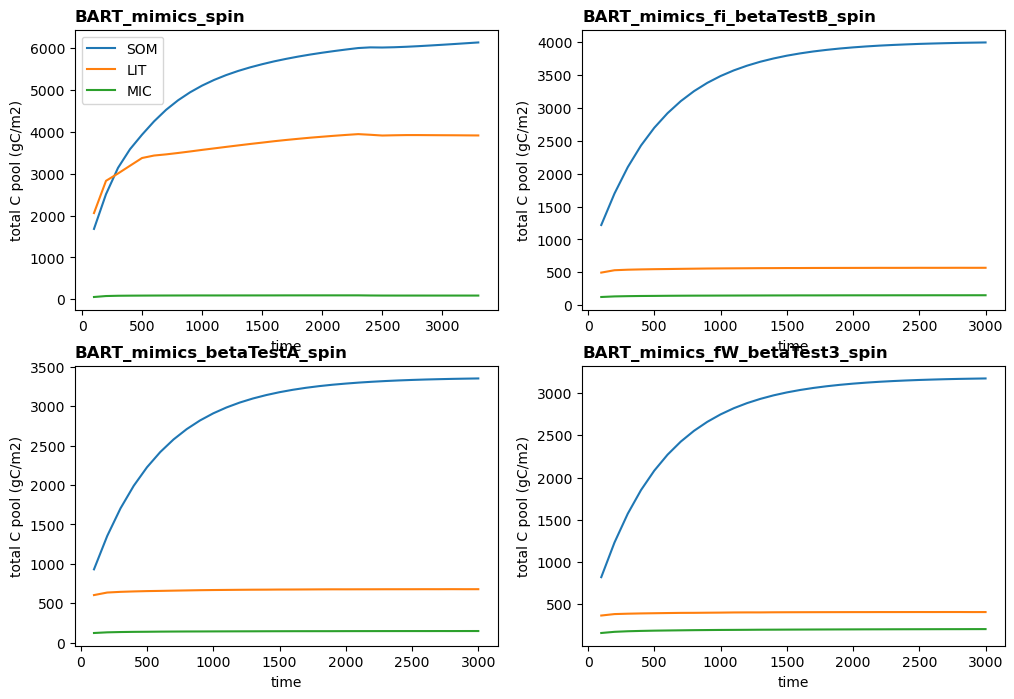

In [10]:
plt.figure(figsize=[12,8])
plt.subplot(2, 2, 1)
ds0.TOTSOMC.plot(label='SOM')
ds0.TOTLITC.plot(label='LIT')
ds0.TOTMICC.plot(label='MIC')
plt.ylabel('total C pool (gC/m2)')
plt.title(cases[0], loc='left', fontsize='large', fontweight='bold')
plt.legend() ;

plt.subplot(2, 2, 2)
ds1.TOTSOMC.plot(label='SOM')
ds1.TOTLITC.plot(label='LIT')
ds1.TOTMICC.plot(label='MIC')
plt.ylabel('total C pool (gC/m2)')
plt.title(cases[1], loc='left', fontsize='large', fontweight='bold') ;

plt.subplot(2, 2, 3)
ds2.TOTSOMC.plot(label='SOM')
ds2.TOTLITC.plot(label='LIT')
ds2.TOTMICC.plot(label='MIC')
plt.ylabel('total C pool (gC/m2)')
plt.title(cases[2], loc='left', fontsize='large', fontweight='bold') ;

plt.subplot(2, 2, 4)
ds3.TOTSOMC.plot(label='SOM')
ds3.TOTLITC.plot(label='LIT')
ds3.TOTMICC.plot(label='MIC')
plt.ylabel('total C pool (gC/m2)')
plt.title(cases[3], loc='left', fontsize='large', fontweight='bold') ;

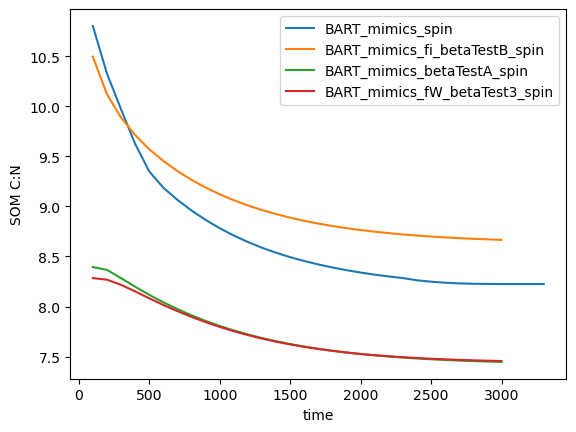

In [11]:
(ds0.TOTSOMC/ds0.TOTSOMN).plot(label=cases[0])
(ds1.TOTSOMC/ds1.TOTSOMN).plot(label=cases[1])
(ds2.TOTSOMC/ds2.TOTSOMN).plot(label=cases[2]) 
(ds3.TOTSOMC/ds3.TOTSOMN).plot(label=cases[3]) 
plt.ylabel('SOM C:N')
plt.legend() ;

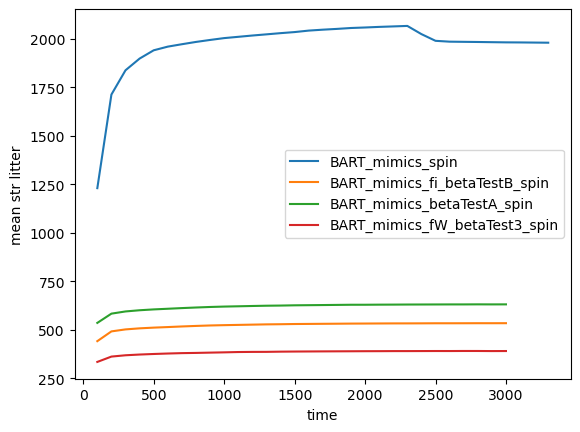

In [12]:
ds0.LIT_STR_C_vr.mean('levsoi').plot(label=cases[0])
ds1.LIT_STR_C_vr.mean('levsoi').plot(label=cases[1])
ds2.LIT_STR_C_vr.mean('levsoi').plot(label=cases[2])
ds3.LIT_STR_C_vr.mean('levsoi').plot(label=cases[3])
plt.ylabel('mean str litter')
plt.legend() ;

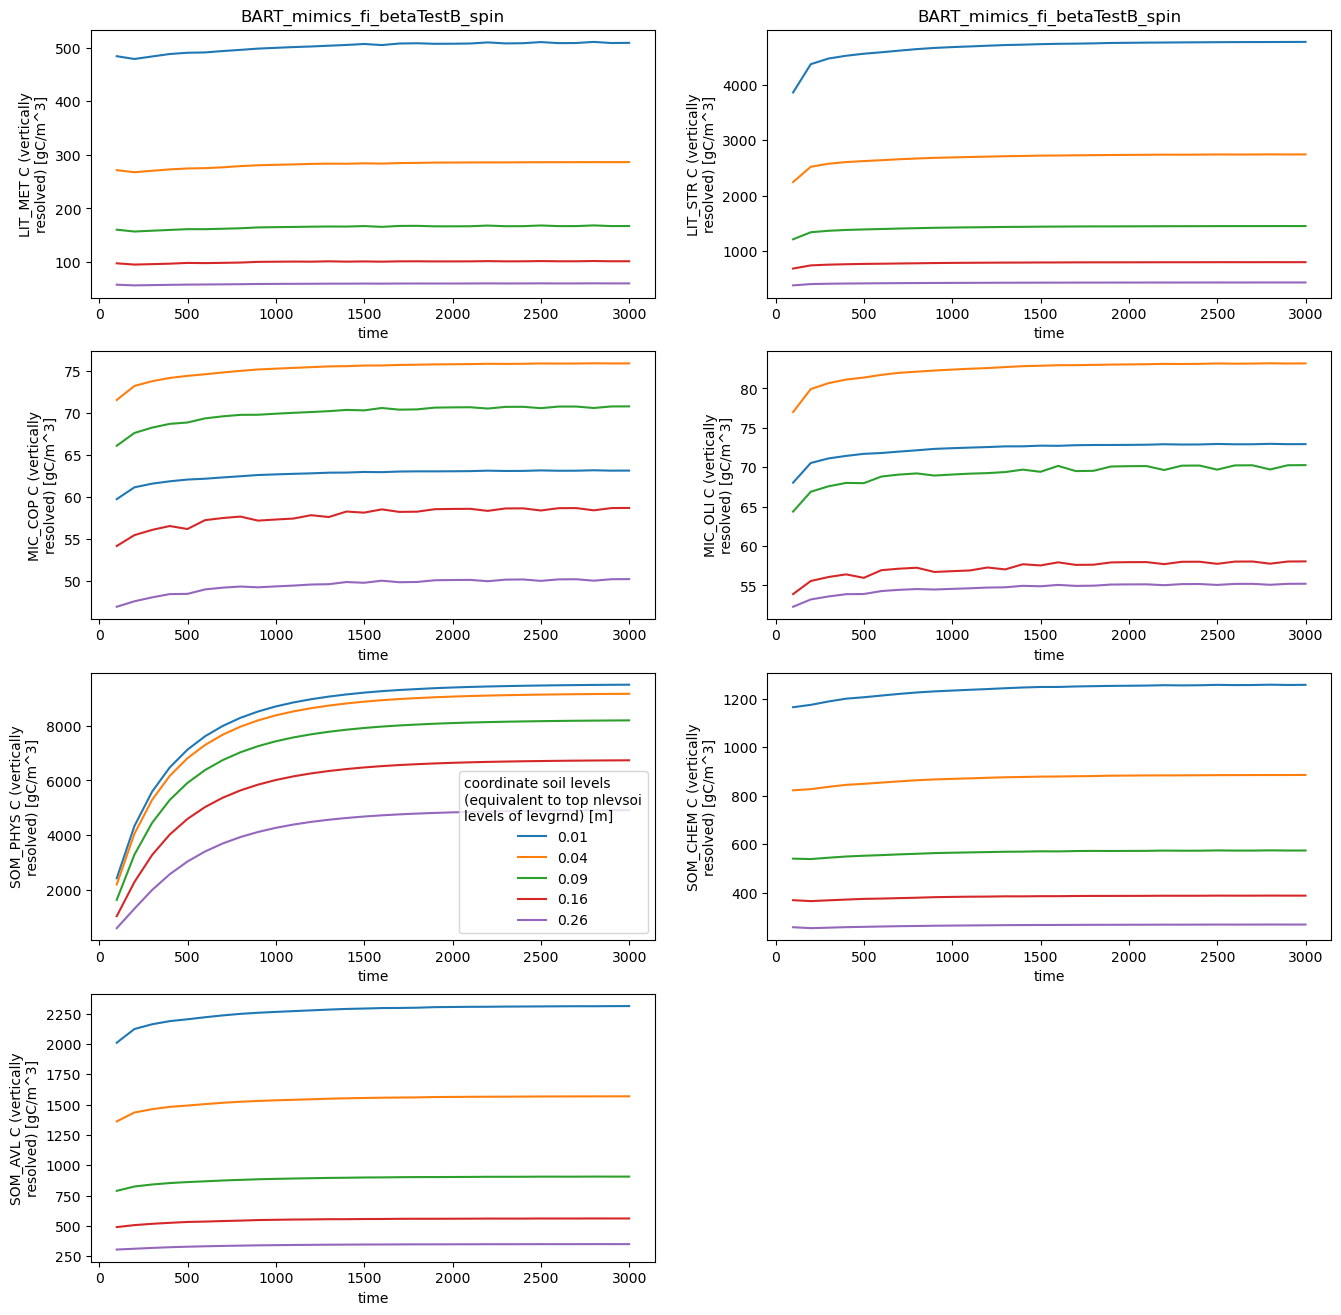

In [13]:
plt.figure(figsize=[16,16])
var=['LIT_MET_C_vr','LIT_STR_C_vr',
     'MIC_COP_C_vr','MIC_OLI_C_vr',
     'SOM_PHYS_C_vr','SOM_CHEM_C_vr','SOM_AVL_C_vr']
for i in range(len(var)):
    plt.subplot(4, 2, (1+i))
    if i != 4: ds1[var[i]].isel(levsoi=slice(0,5)).plot(hue='levsoi',add_legend=False) 
    else: ds1[var[i]].isel(levsoi=slice(0,5)).plot(hue='levsoi',add_legend=True)
    if i <= 1: plt.title(cases[1])
    #plt.yscale('log',base=10) 

In [14]:
### Lots of SOMa, is parameterization working as expected, check KO

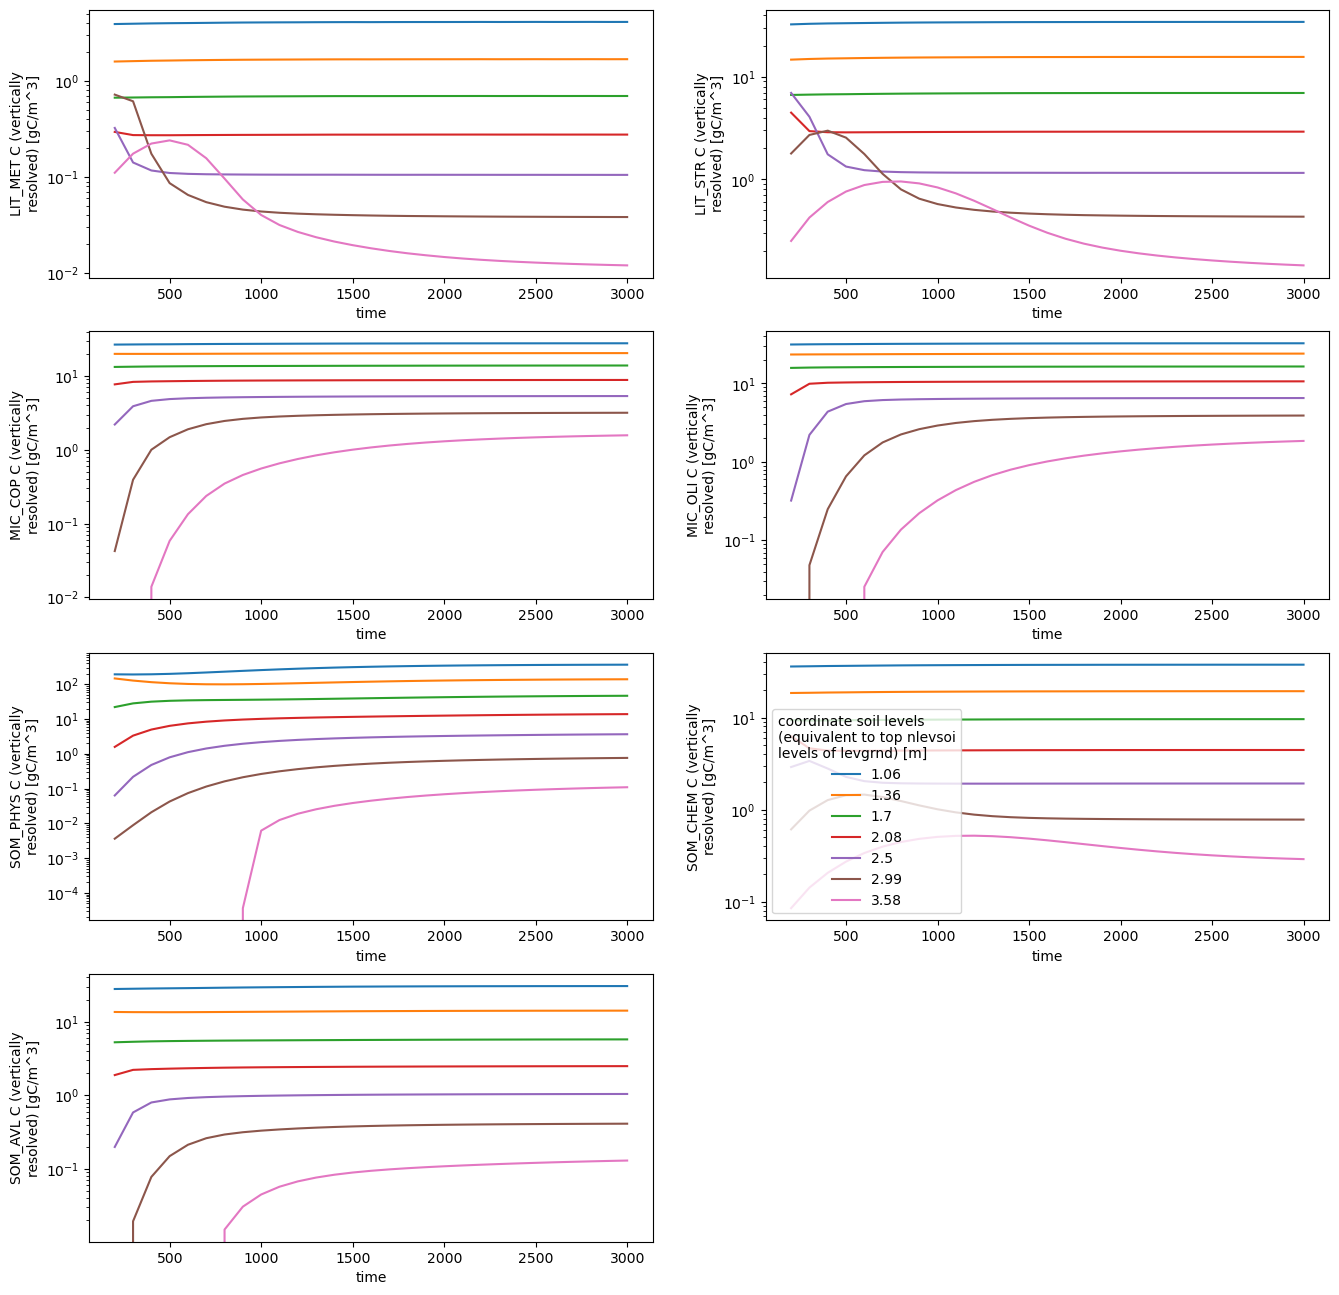

In [15]:
plt.figure(figsize=[16,16])
ftime=1 #skip first 100 time steps
for i in range(len(var)):
    plt.subplot(4, 2, (1+i))
    if i != 5: ds1[var[i]].isel(levsoi=slice(8,15),time=slice(ftime,None)).plot(hue='levsoi',add_legend=False) 
    else: ds1[var[i]].isel(levsoi=slice(8,15),time=slice(ftime,None)).plot(hue='levsoi',add_legend=True)
    plt.yscale('log',base=10) 

### If there's no microbial biomass in lower horizons, LIT and SOM pools accumulating

### Look at 

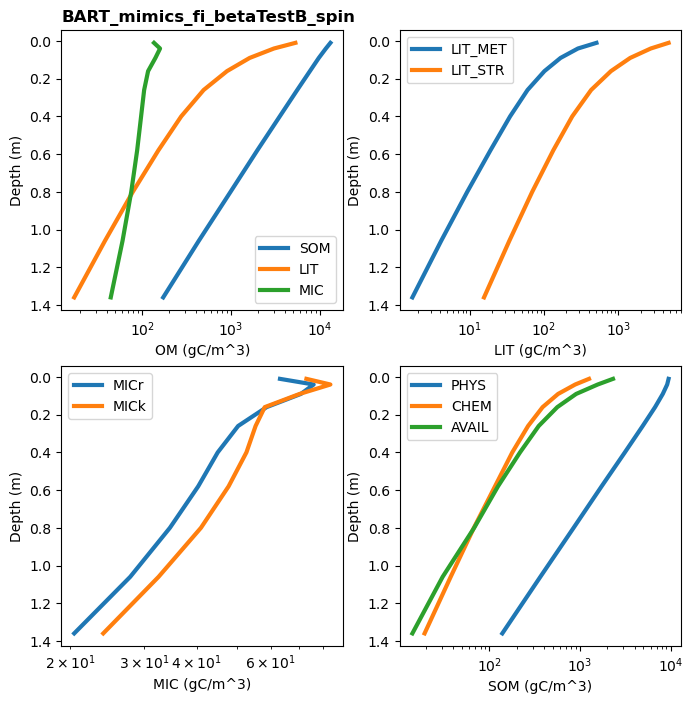

In [16]:
plt.figure(figsize=[8,8])
nbot = 10

plt.subplot(2, 2, 1)
x = ds1.TOT_SOM_C_vr.isel(time=-1).isel(levsoi=slice(0,nbot))
x2 = ds1.TOT_LIT_C_vr.isel(time=-1).isel(levsoi=slice(0,nbot))
x3 = ds1.TOT_MIC_C_vr.isel(time=-1).isel(levsoi=slice(0,nbot))
y = ds1.levsoi.isel(levsoi=slice(0,nbot))
plt.plot(x,y,lw=3,label='SOM') 
plt.plot(x2,y,lw=3,label='LIT') 
plt.plot(x3,y,lw=3,label='MIC') 
plt.xlabel('OM ('+ds1.TOT_SOM_C_vr.attrs['units']+')')
plt.ylabel('Depth (m)')
plt.title(cases[1], loc='left', fontsize='large', fontweight='bold') ;
plt.xscale('log',base=10) 
plt.legend()
plt.gca().invert_yaxis() ;

plt.subplot(2, 2, 2)
x = ds1.LIT_MET_C_vr.isel(time=-1).isel(levsoi=slice(0,nbot))#*1e-3#.plot();
x2 = ds1.LIT_STR_C_vr.isel(time=-1).isel(levsoi=slice(0,nbot))#*1e-3#.plot();
y = ds1.levsoi.isel(levsoi=slice(0,nbot))
plt.plot(x,y,lw=3,label='LIT_MET') 
plt.plot(x2,y,lw=3,label='LIT_STR') 
plt.xlabel('LIT ('+ds1.LIT_MET_C_vr.attrs['units']+')')
plt.ylabel('Depth (m)')
plt.xscale('log',base=10) 
plt.legend()
plt.gca().invert_yaxis() ;

plt.subplot(2, 2, 3)
x = ds1.MIC_COP_C_vr.isel(time=-1).isel(levsoi=slice(0,nbot))#*1e-3#.plot();
x2 = ds1.MIC_OLI_C_vr.isel(time=-1).isel(levsoi=slice(0,nbot))#*1e-3#.plot();
y = ds1.levsoi.isel(levsoi=slice(0,nbot))
plt.plot(x,y,lw=3,label='MICr') 
plt.plot(x2,y,lw=3,label='MICk') 
plt.xlabel('MIC ('+ds1.MIC_COP_C_vr.attrs['units']+')')
plt.ylabel('Depth (m)')
plt.xscale('log',base=10) 
plt.legend()
plt.gca().invert_yaxis() ;

plt.subplot(2, 2, 4)
x = ds1.SOM_PHYS_C_vr.isel(time=-1).isel(levsoi=slice(0,nbot))#*1e-3#.plot();
x2 = ds1.SOM_CHEM_C_vr.isel(time=-1).isel(levsoi=slice(0,nbot))#*1e-3#.plot();
x3 = ds1.SOM_AVL_C_vr.isel(time=-1).isel(levsoi=slice(0,nbot))#*1e-3#.plot();
y = ds1.levsoi.isel(levsoi=slice(0,nbot))
plt.plot(x,y,lw=3,label='PHYS') 
plt.plot(x2,y,lw=3,label='CHEM') 
plt.plot(x3,y,lw=3,label='AVAIL') 
plt.xlabel('SOM ('+ds1.SOM_AVL_C_vr.attrs['units']+')')
plt.ylabel('Depth (m)')
plt.xscale('log',base=10) 
plt.legend()
plt.gca().invert_yaxis() ;



In the original (default) case I was not really happy with the depth dynamics of CHEM and AVAIL pools, which likely are reflecting common microbial kinnetics through the profile. For example, Ying-Ping's 2014 paper suggested the following steady state soil C pool for a 3-pool model

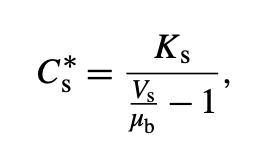.

Should turnover be depth dependent, based on inputs?
Switching to the beta function seems to improve this, but is also makes depth profiles of MICr:MICk more similar.

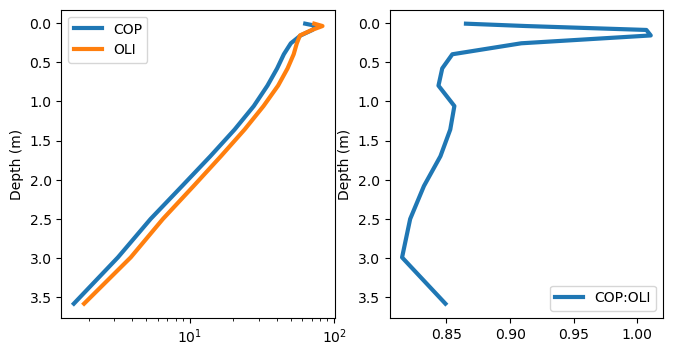

In [17]:
plt.figure(figsize=[12,4])
nbot = 15

plt.subplot(1, 3, 1)
# More oligotrophs at depth!
x = ds1.MIC_COP_C_vr.isel(time=-1,levsoi=slice(0,nbot)) 
x2 = ds1.MIC_OLI_C_vr.isel(time=-1,levsoi=slice(0,nbot))
y = ds1.levsoi.isel(levsoi=slice(0,nbot))

plt.plot(x,y,lw=3,label='COP') 
plt.plot(x2,y,lw=3,label='OLI') 
plt.ylabel('Depth (m)')
plt.legend()
plt.xscale('log',base=10) 
plt.gca().invert_yaxis() ;

plt.subplot(1, 3, 2)
x = (ds1.MIC_COP_C_vr.isel(time=-1) / ds1.MIC_OLI_C_vr.isel(time=-1)).isel(levsoi=slice(0,nbot))

plt.plot(x,y,lw=3,label='COP:OLI') 
plt.ylabel('Depth (m)')
plt.legend()
plt.gca().invert_yaxis() ;

In [18]:
pathIN = '/glade/campaign/cgd/tss/slevis/ctsm_offline/cases_mimics/'
pathINcen = pathIN +'init_stock_1_test/200_and_400_yrs/lnd/hist/'

# read in every 10 years from CENTURY spinup
adIN = pathINcen + 'adspinup/*0-01-01-00000.nc'
padIN = pathINcen + 'post_ad/*0-01-01-00000.nc'
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ad = xr.open_mfdataset(adIN)
    pad = xr.open_mfdataset(padIN)

OSError: no files to open

In [5]:
adIN

'/glade/campaign/cgd/tss/slevis/ctsm_offline/cases_mimics/init_stock_1_test/200_and_400_yrs/lnd/hist/adspinup/*0-01-01-00000.nc'

No handles with labels found to put in legend.


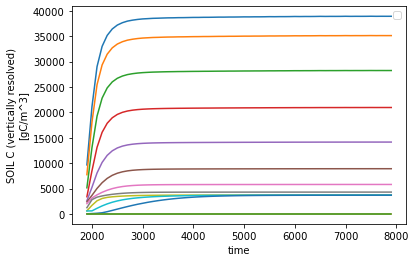

In [91]:
mim.SOILC_vr.isel(levsoi=slice(0,13)).plot(hue='levsoi') ;
plt.legend() ;


In [47]:
mim.SOILC_vr.isel(time=-1).values#.plot();

array([38918.766 , 35115.88  , 28237.92  , 20955.25  , 14148.357 ,
        8902.155 ,  5801.473 ,  4297.0117,  3720.3672,  3706.0095,
        3687.863 ,     0.    ,     0.    ,     0.    ,     0.    ,
           0.    ,     0.    ,     0.    ,     0.    ,     0.    ],
      dtype=float32)

In [1]:
x1 = pad.SOILC_vr.isel(time=-1).isel(levsoi=slice(0,13))#+1e-4#.plot();
x2 = mim.SOILC_vr.isel(time=-1).isel(levsoi=slice(0,13))#+1e-4#.plot();
y = mim.levsoi.isel(levsoi=slice(0,13))
plt.plot(x1,y,lw=3)
plt.plot(x2,y,lw=3) 
#plt.xscale('log')
plt.gca().invert_yaxis()
plt.xlabel('Total soil C ('+ mim.SOILC_vr.attrs['units']+')', 
           fontsize='large', fontweight='bold')
plt.ylabel('Depth ('+mim.levsoi.attrs['units']+')', 
           fontsize='large', fontweight='bold')
plt.title('CSTM 5.1 soil carbon (1pt Amazon)',
          loc='left', fontsize='large', fontweight='bold')
plt.legend(['Century','MIMICS'])
plt.grid(True)
plt.show()


NameError: name 'pad' is not defined

In [75]:
y

<xarray.DataArray 'levsoi' (levsoi: 20)>
array([0.01, 0.04, 0.09, 0.16, 0.26, 0.4 , 0.58, 0.8 , 1.06, 1.36, 1.7 , 2.08,
       2.5 , 2.99, 3.58, 4.27, 5.06, 5.95, 6.94, 8.03], dtype=float32)
Coordinates:
  * levsoi   (levsoi) float32 0.01 0.04 0.09 0.16 0.26 ... 5.06 5.95 6.94 8.03
Attributes:
    long_name:  coordinate soil levels (equivalent to top nlevsoi levels of l...
    units:      m